In [51]:
import numpy as np 
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader

import os
import sys
import yaml
from tqdm import tqdm
import scipy.io as sio
import matplotlib.pyplot as plt

# customized packages
import dataset
import math
import utils
from mlp import projector


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [52]:
############ color dataset ################
N = 48
color_dataset = dataset.Dataset(dataset_type='Color',color_path='./CPdata.mat', N=N)
color_data = color_dataset.getAllData()

############ normal dataset ################
# d: ambient dimension
# r: metric rank
# n: number of items
# N: number of users
# m: number of measurements per user
# noise_type: type of noise in measurement model, from {'none', 'logistic'}
# noise_param: noise parameter, if relevant (in 'logistic' noise, is noise scaling parameter)
# X: X: if None, generates new data. Else, specifies item matrix

pms = {'d': 2, 'r': 2, 'n': 100,'N': 3, 'm':30, 'noise_type':'none', 'noise_param':None, 'X':None}
N = pms['N']

# train_frac = 0.5 # train/test split fraction, specifically equal to # train points / total data
# n_splits =  5 # k-fold number of splits (defunct)
# loss_fun = 'logistic' # loss function for ERM
# use_oracle = True # use oracle hyperparameters
# hyper_sweep = [] # (relative) hyperparameter magnitudes for hyperparameter sweep
# m_train = 300 # number of training comparisons per user
# m_train_res = 30

normal_dataset = dataset.Dataset(dataset_type='Normal', d=pms['d'], 
                                 r=pms['d'], n=pms['n'], 
                                 N=pms['N'], m=pms['m'], 
                                 noise_type=pms['noise_type'], 
                                 noise_param=pms['noise_param'], X=None)

normal_data = normal_dataset.getAllData()

items = normal_data['X']
observations = normal_data['S']
true_y = normal_data['Y']
true_M = normal_data['M']
true_u = normal_data['U']

obs_train, obs_test, Y_train, Y_test = normal_dataset.getTrainTestSplit(train_size=0.75)

In [53]:
# initialize both M and u_s
net = projector(feature_dim=2, num_layer=1, num_class=2, bias_ind=False)
us = []
for i in range(N):
    us.append(torch.randn(3,requires_grad=True))

In [54]:
# true prediction (just for verification) original version
delta_s = []
pred_ys = []
for obs in observations:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    delta = (items[:,x_i]-true_u[:,user_id]).T @ true_M @ (items[:,x_i]-true_u[:,user_id]) - (items[:,x_j]-true_u[:,user_id]).T @ true_M @ (items[:,x_j]-true_u[:,user_id])
    delta_s.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys.append(pred_y)
assert np.all(pred_ys == true_y)

In [55]:
true_L = np.linalg.cholesky(true_M)  # true_M = L @ L.T
with torch.no_grad():
    net.layers.weight.copy_(torch.Tensor(true_L.T))

# true prediction (just for verification) but pytorch version
delta_s_torch = []
pred_ys_torch = []
for obs in observations:
    user_id, comparison_pair = obs
    x_i, x_j = comparison_pair
    x_i, x_j = torch.Tensor(items[:,x_i]), torch.Tensor(items[:,x_j])
    u = torch.Tensor(true_u[:,user_id])
    with torch.no_grad():
        ele_1 = net(x_i-u)
        ele_2 = net(x_j-u)
    delta = ele_1.T @ ele_1 - ele_2.T @ ele_2
    delta_s_torch.append(delta)
    if delta > 0:
        pred_y = 1
    else:
        pred_y = -1
    pred_ys_torch.append(pred_y)

assert np.all(pred_ys_torch == true_y)

In [152]:
# attempt 1: update only M but no user update! (use the true u here)
epochs = 100
bs = 4
lr = 1e-3
momentum = 0.9
weight_decay = 0.001

############ initialize both M and u_s ################
net = projector(feature_dim=2, num_layer=1, num_class=2, bias_ind=False)
us = []
for i in range(N):
    us.append(torch.randn(3,requires_grad=True))


############ define loss and optimizer ################
def hinge_loss(outputs, targets):   # written by the gpt-4 :)
    """
    Hinge loss for binary classification.

    Parameters:
    outputs (torch.Tensor): Output from the model (before activation function like sigmoid).
    targets (torch.Tensor): Ground truth labels, expected to be +1 or -1.

    Returns:
    torch.Tensor: Calculated hinge loss.
    """
    hinge_loss_value = 1 - targets * outputs
    hinge_loss_value = torch.clamp(hinge_loss_value, min=0)
    return hinge_loss_value.mean()

loss_fn = hinge_loss
optimizer = torch.optim.SGD(net.parameters(),lr=lr,momentum=momentum,weight_decay=weight_decay)

############ define dataloader ################
class CustomDataset(Dataset):   # written by the gpt-4 :)
    def __init__(self, data_list):
        self.data_list = data_list

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        return self.data_list[idx]
    
train_dataset = CustomDataset(list(zip(obs_train, Y_train)))
train_dataloader = DataLoader(train_dataset, batch_size=bs, shuffle=True)

test_dataset = CustomDataset(list(zip(obs_test, Y_test)))
test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

############ define training function ################
def train(net,optimizer,loss_fn,train_loader,test_loader,epochs):
    train_stats = {
        'train_loss_per_batch_record': [],
        'train_accu_record': [],
        'test_loss_per_batch_record': [],
        'test_accu_record': [],
        'relative_metric_error_record': [],
    }

    for ep in range(epochs):
        for x,y in train_loader:
            optimizer.zero_grad()

            user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
            # print(x)
            # print(user_ids)
            # print(x_is)
            # print(x_js)
            # print(y)

            x_is, x_js = torch.Tensor(items[:,x_is]), torch.Tensor(items[:,x_js])
            us = torch.Tensor(true_u[:,user_ids])
            # print('x_is', x_is)
            # print('x_js', x_js)
            # print('us', us)

            x_is_minus_us = (x_is - us).T
            x_js_minus_us = (x_js - us).T
            
            ele_1 = net(x_is_minus_us)
            ele_2 = net(x_js_minus_us)

            # print(ele_1.shape)
            # print(ele_2.shape)

            delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
            
            # print(delta)
            acc_batch = torch.sum((delta * y)>0)
            # print(f'prediction_accu: {acc_batch/bs}')
            
            L = net.layers.weight
            relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
            train_stats['relative_metric_error_record'].append(relative_metric_error.item())

            loss = loss_fn(delta,y)
            # print(loss)

            train_stats['train_loss_per_batch_record'].append(loss.item())
            train_stats['train_accu_record'].append(acc_batch/bs)

            # Backward and optimize
            loss.backward()
            optimizer.step()
        
        val_stat = val(net,loss_fn,test_loader)
        train_stats['test_loss_per_batch_record'].extend(val_stat['test_loss_per_batch'])
        train_stats['test_accu_record'].append(val_stat['test_accu'])
    return train_stats

############ define val function ################
def val(net,loss_fn,test_loader):
    total_val_samples = len(test_dataloader.dataset)
    val_stat = {
        'test_correct': 0,
        'test_loss_per_batch': [],
        'test_accu': 0
    }

    with torch.no_grad():
        for x,y in test_loader:
            user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
            x_is, x_js = torch.Tensor(items[:,x_is]), torch.Tensor(items[:,x_js])
            us = torch.Tensor(true_u[:,user_ids])
            x_is_minus_us = (x_is - us).T
            x_js_minus_us = (x_js - us).T
            ele_1 = net(x_is_minus_us)
            ele_2 = net(x_js_minus_us)
            delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
            acc_batch = torch.sum((delta * y)>0)
            loss = loss_fn(delta,y)

            val_stat['test_correct'] += acc_batch.item()
            val_stat['test_loss_per_batch'].append(loss.item())
    
    val_stat['test_accu'] = val_stat['test_correct'] / total_val_samples

    return val_stat






23

In [112]:
true_L = np.linalg.cholesky(true_M)  # true_M = L @ L.T
with torch.no_grad():
    net.layers.weight.copy_(torch.Tensor(true_L.T))

In [130]:
loss_record = []
accu_record = []
relative_metric_error_record = []

for ep in range(epochs):
    for x,y in train_dataloader:
        optimizer.zero_grad()

        user_ids, x_is, x_js = x[0], x[1][0], x[1][1]
        # print(x)
        # print(user_ids)
        # print(x_is)
        # print(x_js)
        # print(y)

        x_is, x_js = torch.Tensor(items[:,x_is]), torch.Tensor(items[:,x_js])
        us = torch.Tensor(true_u[:,user_ids])
        # print('x_is', x_is)
        # print('x_js', x_js)
        # print('us', us)

        x_is_minus_us = (x_is - us).T
        x_js_minus_us = (x_js - us).T
        
        ele_1 = net(x_is_minus_us)
        ele_2 = net(x_js_minus_us)

        # print(ele_1.shape)
        # print(ele_2.shape)

        delta = torch.sum(ele_1 * ele_1, dim=1) - torch.sum(ele_2 * ele_2, dim=1)
        
        # print(delta)
        acc_batch = torch.sum((delta * y)>0)
        # print(f'prediction_accu: {acc_batch/bs}')
        
        L = net.layers.weight
        relative_metric_error = torch.norm(L.T @ L - torch.tensor(true_M)) / torch.norm(torch.tensor(true_M))
        relative_metric_error_record.append(relative_metric_error.item())

        loss = loss_fn(delta,y)
        # print(loss)

        loss_record.append(loss.item())
        accu_record.append(acc_batch/bs)
        # Backward and optimize
        loss.backward()
        optimizer.step()

In [153]:
train_stats = train(net, optimizer, loss_fn, train_dataloader, test_dataloader, epochs)

Text(0, 0.5, 'train_loss_per_batch_record')

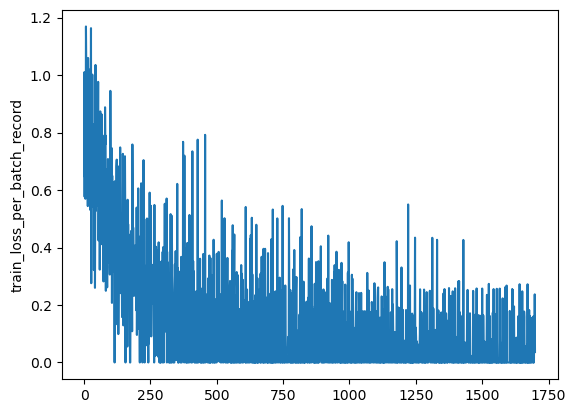

In [154]:
plt.plot(train_stats['train_loss_per_batch_record'])
plt.ylabel('train_loss_per_batch_record')

Text(0, 0.5, 'train_accu_record')

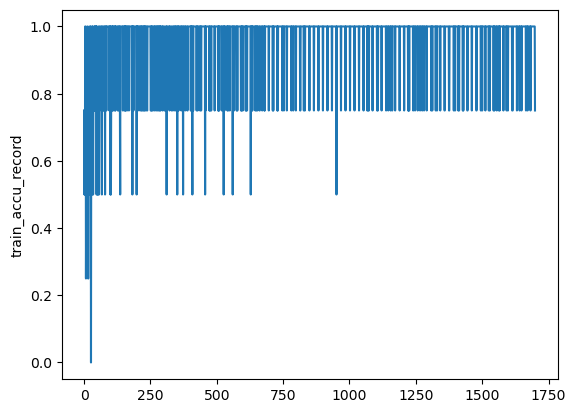

In [155]:
plt.plot(train_stats['train_accu_record'])
plt.ylabel('train_accu_record')

Text(0, 0.5, 'test_accu_record')

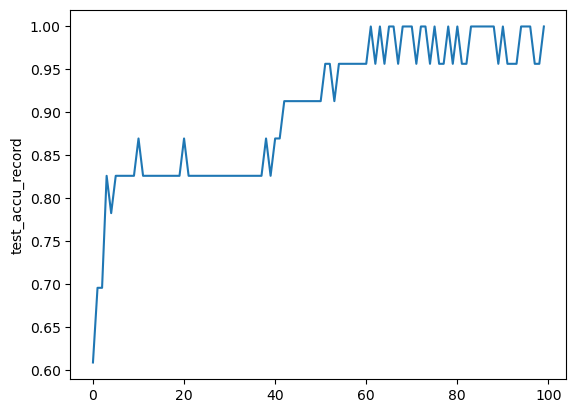

In [156]:
plt.plot(train_stats['test_accu_record'])
plt.ylabel('test_accu_record')

Text(0, 0.5, 'test_loss_per_batch_record')

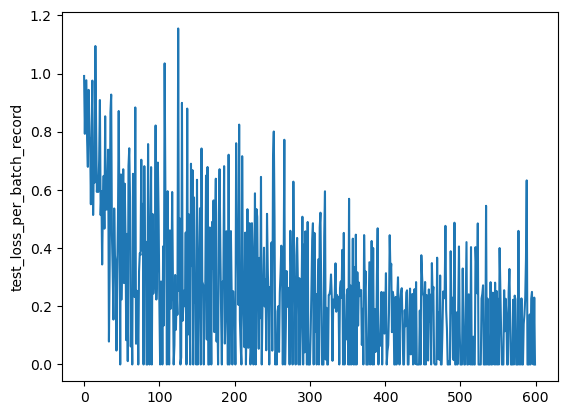

In [157]:
plt.plot(train_stats['test_loss_per_batch_record'])
plt.ylabel('test_loss_per_batch_record')

In [134]:
res = val(net, loss_fn, test_dataloader)

In [135]:
res

{'test_correct': 22,
 'test_loss_per_batch': [0.25160133838653564,
  0.22790789604187012,
  0.0,
  0.30389100313186646,
  0.0,
  0.0],
 'test_accu': 0.9565217391304348}

In [405]:
L = net.layers.weight

In [414]:
L.T @ L

tensor([[ 4.0911, -1.9974],
        [-1.9974,  1.2564]], grad_fn=<MmBackward0>)

In [407]:
true_L = np.linalg.cholesky(true_M)

In [411]:
true_L @ true_L.T

array([[ 1.47929316, -0.86198852],
       [-0.86198852,  0.57065167]])

In [412]:
true_M

array([[ 1.47929316, -0.86198852],
       [-0.86198852,  0.57065167]])

In [ ]:
user_id, comparison_pair = obs
x_i, x_j = comparison_pair
x_i, x_j = torch.Tensor(items[:,x_i]), torch.Tensor(items[:,x_j])
u = torch.Tensor(true_u[:,user_id])
with torch.no_grad():
    ele_1 = net(x_i-u)
    ele_2 = net(x_j-u)
delta = ele_1.T @ ele_1 - ele_2.T @ ele_2

In [224]:
list(zip(observations,true_y))

[((0, (39, 82)), 1.0),
 ((0, (26, 57)), 1.0),
 ((0, (74, 36)), -1.0),
 ((0, (13, 80)), -1.0),
 ((0, (50, 55)), -1.0),
 ((0, (72, 34)), 1.0),
 ((0, (59, 50)), 1.0),
 ((0, (4, 25)), -1.0),
 ((0, (81, 69)), 1.0),
 ((0, (80, 1)), 1.0),
 ((0, (54, 68)), -1.0),
 ((0, (40, 52)), 1.0),
 ((0, (26, 32)), -1.0),
 ((0, (9, 6)), -1.0),
 ((0, (37, 39)), -1.0),
 ((0, (2, 55)), -1.0),
 ((0, (67, 51)), -1.0),
 ((0, (66, 59)), -1.0),
 ((0, (4, 84)), -1.0),
 ((0, (77, 41)), -1.0),
 ((0, (96, 80)), -1.0),
 ((0, (1, 5)), -1.0),
 ((0, (62, 66)), 1.0),
 ((0, (34, 28)), -1.0),
 ((0, (77, 21)), -1.0),
 ((0, (1, 90)), 1.0),
 ((0, (82, 33)), -1.0),
 ((0, (65, 43)), -1.0),
 ((0, (78, 80)), -1.0),
 ((0, (99, 72)), 1.0),
 ((1, (72, 64)), -1.0),
 ((1, (5, 49)), 1.0),
 ((1, (95, 53)), 1.0),
 ((1, (41, 42)), 1.0),
 ((1, (52, 50)), -1.0),
 ((1, (76, 2)), -1.0),
 ((1, (71, 88)), -1.0),
 ((1, (27, 59)), 1.0),
 ((1, (94, 89)), -1.0),
 ((1, (31, 92)), 1.0),
 ((1, (37, 13)), -1.0),
 ((1, (52, 78)), 1.0),
 ((1, (90, 35)), -1